https://www.kaggle.com/mczielinski/bitcoin-historical-data/download

In [5]:
pip install chart_studio

    100% |████████████████████████████████| 71kB 1.2MB/s 
  Using cached https://files.pythonhosted.org/packages/bf/5f/47ab0d9d843c5be0f5c5bd891736a4c84fa45c3b0a0ddb6b6df7c098c66f/plotly-4.9.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ee/ff/48bde5c0f013094d729fe4b0316ba2a24774b3ff1c52d924a8a4cb04078a/six-1.15.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/45/1e/0c169c6a5381e241ba7404532c16a21d86ab872c9bed8bdcd4c423954103/requests-2.24.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a2/38/928ddce2273eaa564f6f50de919327bf3a00f091b5baba8dfa9460f3a8a8/idna-2.10-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5e/c4/6c4fe722df5343c33226f0b4e0bb042e4dc13483228b4718baf286f86d87/certifi-2020.6.20-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bc/a9/01ffebfb562e4274b6487b4bb1ddec7ca55ec7510b22e4c51f14098443b8/chardet-3.0.4-py2.py3-none-any.whl
  

In [82]:
from io import BytesIO, StringIO
from smart_open import open as sopen
import pandas as pd
import csv
import json
import datetime

import re
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/hmayt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [83]:
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import datetime, pytz

import matplotlib.pyplot as plt





In [12]:
# df1 = pd.DataFrame(simple_list,columns=columns)
# df1['Volume_(BTC)'].fillna(value=0, inplace=True)
# df1['Volume_(Currency)'].fillna(value=0, inplace=True)
# df1['Weighted_Price'].fillna(value=0, inplace=True)
# df1['Open'].fillna(method='ffill', inplace=True)
# df1['High'].fillna(method='ffill', inplace=True)
# df1['Low'].fillna(method='ffill', inplace=True)
# df1['Close'].fillna(method='ffill', inplace=True)
# df1[['Timestamp','High']]

In [84]:
url = 'gs://workflowkddc/Bitcoin/price/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv'
with sopen(url,'r') as r:
    tp = pd.read_csv(r, iterator=True, chunksize=1000, usecols =['Timestamp',  'High'])  # gives TextFileReader, which is iterable with chunks of 1000 rows.
    df = pd.concat(tp, ignore_index=True)  # df is DataFrame. If errors, do `list(tp)` instead of `tp`


In [11]:
df.columns

Index(['Timestamp', 'High', 'Volume_(BTC)'], dtype='object')

In [85]:

df['Volume_(BTC)'].fillna(value=0, inplace=True)
df['High'].fillna(method='ffill', inplace=True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

In [86]:

# df_all = pd.DataFrame()
with sopen('gs://workflowkddc/Bitcoin/comments/gold/dollar_mention.txt','r') as r:
    df_c = pd.read_json(r.read(), lines=True)

In [87]:
df_c = df_c.explode('dollar_comment')
df_c["k"]= None
df_c["k"]=df_c["k"].astype(bool)
for index, row in df_c.iterrows():
    if str(row['dollar_comment'])[-4].lower() == 'k' or str(row['dollar_comment'])[-1].lower() == 'k':
        df_c.at[index, 'k'] = True

In [88]:

df_c['dollar_comment'] = df_c['dollar_comment'].apply(lambda x : re.sub('[^0-9^.]','', x))
df_c['dollar_comment'] = pd.to_numeric(df_c['dollar_comment'], errors='coerce')
df_c = df_c.dropna()
df_c['created_utc'] = pd.to_datetime(df_c['created_utc'],unit='s')

In [89]:
for index, row in df_c.iterrows():
    if row['k'] == True:
        df_c.at[index,'dollar_comment'] = float(row['dollar_comment']*1000)
 
# [^0-9^.]

In [49]:
df_c.columns

Index(['created_utc', 'dollar_comment', 'author'], dtype='object')

In [90]:
df_c95 = df_c[df_c['dollar_comment'] < df_c['dollar_comment'].quantile(0.95) ]

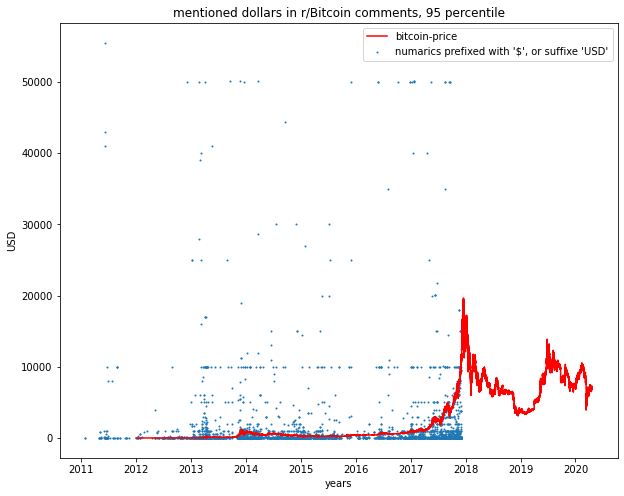

In [81]:

f, ax1 = plt.subplots(1, sharey=True)
f.set_size_inches(10, 8)

ax1.plot( df['Timestamp'], df['High'], color='red', label='bitcoin-price')
ax1.set_title('mentioned dollars in r/Bitcoin comments, 95 percentile')

# f.suptitle('bold figure suptitle', fontsize=14, fontweight='bold')
ax1.scatter(df_c95['created_utc'], df_c95['dollar_comment'],s=1, label='numarics prefixed with \'$\', or suffixe \'USD\'')
ax1.set_xlabel('years')
ax1.set_ylabel('USD')

plt.legend()
plt.show()

In [21]:
from wfunc import db
db = db.Mydatabase()
db.query( """SELECT 
    t.tsm,
    b.price_high,
    t.co
FROM
(SELECT 
    tsm,
    COUNT(*) AS co
FROM
    redditsub
WHERE 
    LOWER(body)  SIMILAR TO '% *mo+on *%'
GROUP BY 
    tsm) t, bitbase b
WHERE
    t.tsm = b.tsm;

""")

import pandas as pd
df_moon = pd.DataFrame(db.fetcha())
df_moon.columns = ['time','price','moons']
df_moon['time']= pd.to_datetime(df_moon['time'],unit='s')
df_moon.index = df_moon['time']

df_moon['price']= pd.to_numeric(df_moon['price'])
df_moon['price'].fillna(method='ffill', inplace=True)

In [ ]:

df_moon = df_moon.resample('w').agg({"moons":'sum',"price":'mean'})

x = df_moon.index
y = df_moon['price']

s = df_moon['moons']

fig, ax = plt.subplots()

scatter = ax.scatter(x, y, s=s)

handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")

plt.show()